# Style Transfer

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage, Resize, CenterCrop, Compose, Normalize

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(torch.cuda.get_device_name())
else:
    device = torch.device("cpu")

Tesla K80


# The images

In [0]:
"""
Some helper functions
"""
toPIL = ToPILImage()
means = torch.tensor([0.485, 0.456, 0.406]).cpu()
stds = torch.tensor([0.229, 0.224, 0.225]).cpu()
s=300

def get_trans(s=s):
    return Compose([
            Resize(s),
            CenterCrop((s,s)),
            ToTensor(),
            Normalize(means, stds)
    ])

def untrans(img):
    img = img.detach().cpu() * stds.reshape(1,3,1,1) + means.reshape(1,3,1,1)
    return toPIL(img.squeeze())

def mm_norm(img):
    img = img.detach().clone().cpu().squeeze().numpy()
    img -= img.min()
    img /= img.max()
    return img.transpose(1,2,0)

def splot(img, i=1, r=1, c=1):
    plt.subplot(r,c,i)
    try:
        plt.imshow(img)
    except:
        plt.imshow(untrans(img))
    plt.axis('off')

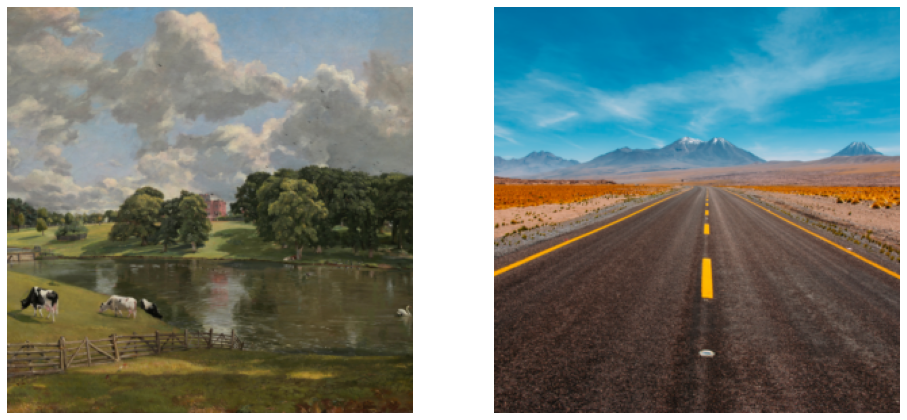

In [3]:
"""
Get the images
"""

styl_ = Image.open("./style.jpg")
cont_ = Image.open("./content.jpeg")

trans = get_trans()
styl = trans(styl_).unsqueeze(0)
cont = trans(cont_).unsqueeze(0)

# Display the images
plt.figure(figsize=(16,9))
splot(styl,1,1,2),splot(cont,2,1,2)
plt.show()

Painting by [John Constable](https://en.wikipedia.org/wiki/John_Constable)  
Photo by [Diego Jimenez](https://unsplash.com/@diegojimenez)

# The network

In [0]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg19
from torchsummary import summary
from tqdm.autonotebook import tqdm
from torch import optim

In [0]:
model__ = vgg19(pretrained=True).eval()
model_ = [*model__.children()][0]
layers = []

# Replace MaxPool with AvgPool like in the paper (better grad flow)
for ch in model_.children():
    if isinstance(ch,nn.MaxPool2d):
        d = {
            'kernel_size' : ch.kernel_size,
            'stride' : ch.stride,
            'padding' : ch.padding,
            'ceil_mode' : ch.ceil_mode
        }
        layers.append(nn.AvgPool2d(**d))
    elif isinstance(ch, nn.ReLU):
        # Works better acc to 
        # https://pytorch.org/tutorials/advanced/neural_style_tutorial.html
        layers.append(nn.ReLU(inplace=False)) 
    else:
        layers.append(ch)
        
model_ = nn.Sequential(*layers)
del layers

**Few Implementation details**
- The model outputs are tapped at the ReLU after the Conv2d layers.
- Regularization constants for the costs ie the MSE divisors not used:
    - Content Cost = $\frac{MSE}{2}$
    - Style Cost = $\frac {MSE}{4N_l^2M_l^2}$
- ImageNet stats based normalization is applied to the content and style image before capturing it's activations.

In [0]:
def forward(x, model=model_):
    """
    Get activations for all conv layers
    """
    model.to(device)
    fp = []
    for child in model.children():
        x = child(x.to(device))
        if isinstance(child, (nn.ReLU)):
            fp.append(x.cpu())
    return fp

def get_layers(model):
    for m in model.modules():
        if len([*m.children()]) == 0:
            yield m

def get_gram(act):
    nc = torch.tensor(act.size()).prod()
    act = act.reshape(act.size(1), -1)
    return (act @ act.T)/nc

def get_grams(acts):
    return [get_gram(act) for act in acts]

In [0]:
class ContentCost(nn.Module):
    def __init__(self, cont_act):
        super().__init__()
        # Reference activation.
        self.ref = cont_act.detach().to(device)
        self.lfn = lambda x: F.mse_loss(x, self.ref)
        
    def forward(self, x_act):
        self.loss =  self.lfn(x_act)
        return x_act
    
class StyleCost(nn.Module):
    def __init__(self, styl_act, lambd=1):
        super().__init__()
        # Reference gram matrix.
        self.ref = get_gram(styl_act).detach().to(device)
        self.lambd = lambd
        self.lfn = lambda x: F.mse_loss(x, self.ref)
        
    def forward(self, x_act):
        x_gram = get_gram(x_act)
        self.loss = self.lfn(x_gram) * self.lambd
        return x_act

In [0]:
content_index = 8
style_indices = [0, 2, 4, 8, 12]

class StyleTransfer(nn.Module):
    def __init__(self, content_image, style_image, lambd=None, style_indices=style_indices, 
                 content_index=content_index, model=model_):
        super().__init__()
        activations = {
            "content":forward(content_image,model),
            "style":  forward(style_image,model),
        }
        if lambd is None:
            lambd = [1]*len(style_indices)
        self._prepare_model(model, activations, content_index, style_indices, lambd)
        
    def _prepare_model(self, model, activations, content_index, style_indices, lambd):
        layers = []
        i = 0
        for layer in model.children():
            if isinstance(layer, nn.ReLU):
                layers.append(layer)
                if i in style_indices:
                    sc = StyleCost(activations["style"][i].detach(), lambd.pop(0))
                    layers.append(sc)
                if i == content_index:
                    cc = ContentCost(activations["content"][i].detach())
                    layers.append(cc)
                i += 1
                if i > content_index and i > max(style_indices):
                    break
            else:
                layers.append(layer)
        self.model = nn.Sequential(*layers).eval()
        
    def loss(self, alpha=None, beta=None):
        cl = 0
        sl = 0
        for ch in self.model:
            if isinstance(ch, ContentCost):
                cl += ch.loss
            if isinstance(ch, StyleCost):
                sl += ch.loss
        if alpha is None or beta is None:
            return cl, sl
        else:
            return alpha*cl + beta*sl
    
    def forward(self, x):
        return self.model(x)

In [0]:
# Values chosen so that the image can be replicated from the 
# first conv layer.
CLIP = (-2.12,2.5)

def fit(target, epochs, optimizer, model, alpha=1, beta=5e3,  losses=None):
    if losses is None:
        losses = []
    pbar = tqdm(total=epochs)
    run = [0]
    model.to(device)
    target = target.to(device)
    try:
        for i in range(epochs):
            # Keeps the target within range
            target.data.clamp_(*CLIP)
            optimizer.zero_grad()
            model(target)
            cl,sl = model.loss()
            cl *= alpha 
            sl *= beta
            loss = cl + sl
            
            loss.backward()
            optimizer.step()

            # Update tqdm
            pbar.desc = f"{cl.item():0.4f} | {sl.item():0.4f} | {loss.item():0.4f}"
            pbar.update(1)
            losses.append(loss.item())
            del loss
    except:
        print("stopping loop")
    target.data.clamp_(*CLIP)
    return losses 

# Using Recommened HParams

Running style transfer using (some of the) hyperparameters recommended in the [paper](https://arxiv.org/abs/1508.06576)
> - replacing the max-pooling operation by average pooling improves the gradient flow and one obtains slightly more appealing results
> - In in Fig 2 we matched the content representation on layer ‘conv4_2’ and the style representations on layers ‘conv1_1’, ‘conv2_1’, ‘conv3_1’, ‘conv4_1’ and ‘conv5_1’  
> - wl = 1/5 in those layers, wl = 0 in all other layers

- The max Pool has been replaced by avg pool in the model definition.
- Using weights of 0.2 for layers 1 through 5.
- Using conv layer 1 in blocks 1 to 5 for style.
- Using conv layer 2 in block 4 for content.
- the $\alpha,\beta$ ratio isn't followed cause the costs are not divided like in the paper.

**The layer naming convention** *(convN_M)* 
- **N** - block number, a block here is delimited by maxpool layers, so $[conv \to relu \to maxpool]$ is one block.
- **M** - conv layer number in block, eg $[conv \to relu \to conv \to relu \to conv \to maxpool]$ has 2 conv layers so $M \in \{1,2\}$
- VGG19 has 5 blocks in total, first 2 blocks have 2 conv layers remaining blocks have 4 conv layers each.
- At the end of the conv parade there are three massive (>123M) fc layers but those aren't used here.

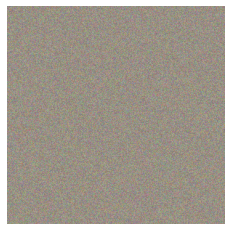

In [0]:
lambd = (np.ones(5)/5).tolist() # the style weights
model = StyleTransfer(cont, styl, lambd).to(device)

target = torch.rand(styl.shape,requires_grad=True, device=device)
alpha = 1.0
beta = 1e5

"""
Pretrained normalized by 
ImageNet stats target noise
image.
"""
splot(target)
plt.show()

In [0]:
# This cell was run multiple times with different settings on the same target.
opt = optim.Adam([target],lr=1e-3)
losses = fit(target, 3000, opt, model, alpha=alpha*1000, beta=beta*1000) 

- The $\alpha,\beta$ ratio is like a knob for controlling how much of style or content is required, the image can be replicated from noise if the refrence content layer is set to 1 and $\beta = 0$.
- Heavy clipping (0,1) prevents the image from being replicated, no clipping causes unsightly pixels.
- More visually pleasing images may be possible if starting not from noise but from the content image.

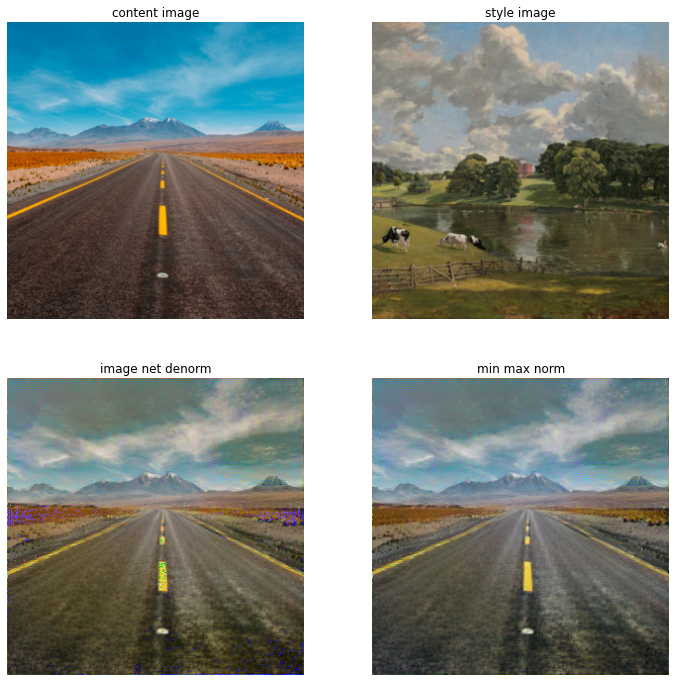

In [0]:
plt.figure(figsize=(12,12))
splot(cont, 1,2,2)
plt.title("content image")
splot(styl, 2,2,2)
plt.title("style image")
splot(target, 3,2,2)
plt.title("image net denorm")
splot(mm_norm(target),4, 2,2)
plt.title("min max norm")
plt.show()

# Not starting from noise

Will see the outcomes when starting from the content image or the style image.

In [0]:
lambd = (np.ones(5)/5).tolist() # the style weights
model = StyleTransfer(cont, styl, lambd).to(device)

target_c = cont.clone().to(device).requires_grad_(True)
target_s = styl.clone().to(device).requires_grad_(True)

alpha = 1.0
beta = 1e5

In [0]:
# This cell was run multiple times with different settings on the same target.

# Run 1 1000 ep 1e-2 lr
# Run 2  500 ep 1e-3 lr

opt = optim.Adam([target_c],lr=1e-3)
losses_c = fit(target_c, 500, opt, model, alpha=alpha*1000, beta=beta*1000) 

opt = optim.Adam([target_s],lr=1e-3)
losses_s = fit(target_s, 500, opt, model, alpha=alpha*1000, beta=beta*1000) 

- Starting from the content image seems to obtain more shapely results (as expected) and also seems to acquire more of the palette of the style image than the texture. 
- Starting from the style image obtains more textural results but the shapes are not recreated as well.

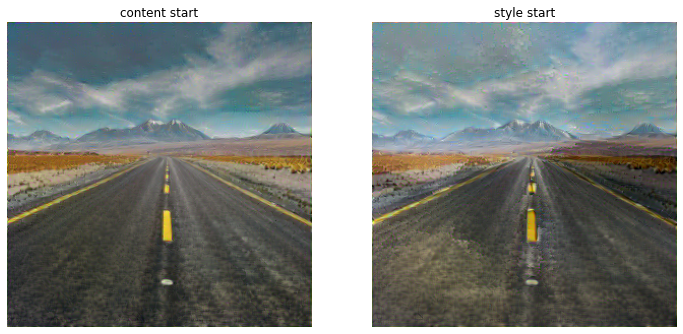

In [0]:
plt.figure(figsize=(12,6))
splot(mm_norm(target_c),1,1,2)
plt.title("content start")
splot(mm_norm(target_s),2,1,2)
plt.title("style start")
plt.show()

# Higher resolutions

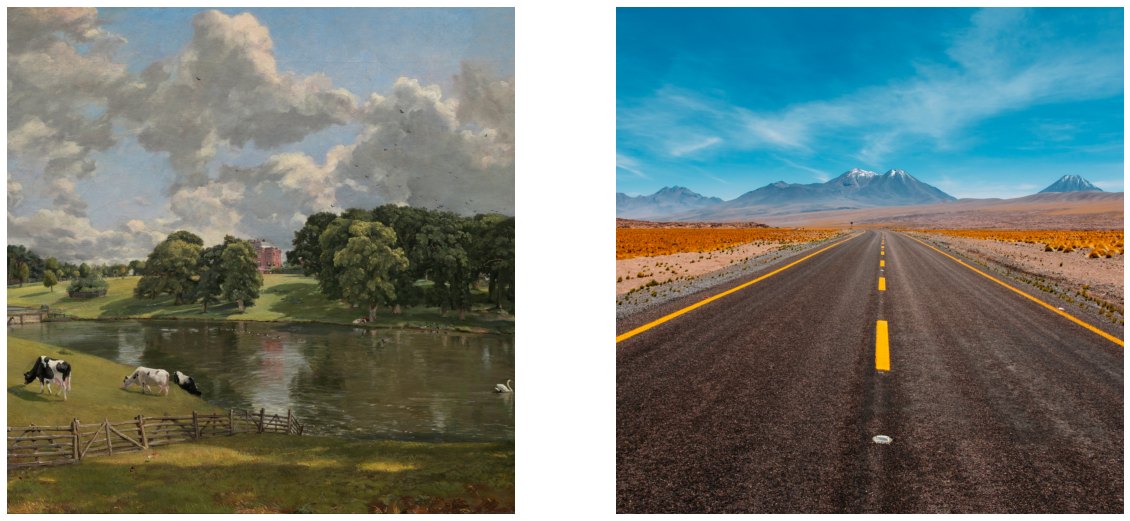

In [10]:
trans = get_trans(1500)
styl = trans(styl_).unsqueeze(0)
cont = trans(cont_).unsqueeze(0)
plt.figure(figsize=(20,10))
splot(styl, 1,1,2),splot(cont, 2,1,2);

In [13]:
print(torch.cuda.memory_summary(abbreviated=True))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  150543 KB |   10848 MB |   15975 MB |   15828 MB |
|---------------------------------------------------------------------------|
| Active memory         |  150543 KB |   10848 MB |   15975 MB |   15828 MB |
|---------------------------------------------------------------------------|
| GPU reserved memory   |   10956 MB |   10956 MB |   10956 MB |       0 B  |
|---------------------------------------------------------------

In [0]:
"""
Starting with the content image
"""
lambd = [1.0, 0.75 ,0.2, 2.2, 2.2] # the style weights
target = cont.clone().to(device).requires_grad_(True)
model = StyleTransfer(cont, styl, lambd).to(device)

alpha = 1.0
beta = 1e5

In [25]:
# Was rerun with different hparams 
# (if some one is reading this, sorry for not noting the hparams)
opt = optim.Adam([target], lr=1e-3)
losses = fit(target, 300, opt, model, alpha*0, beta*100000000)

stopping loop


In [0]:
torch.save(target,"temp.pt")

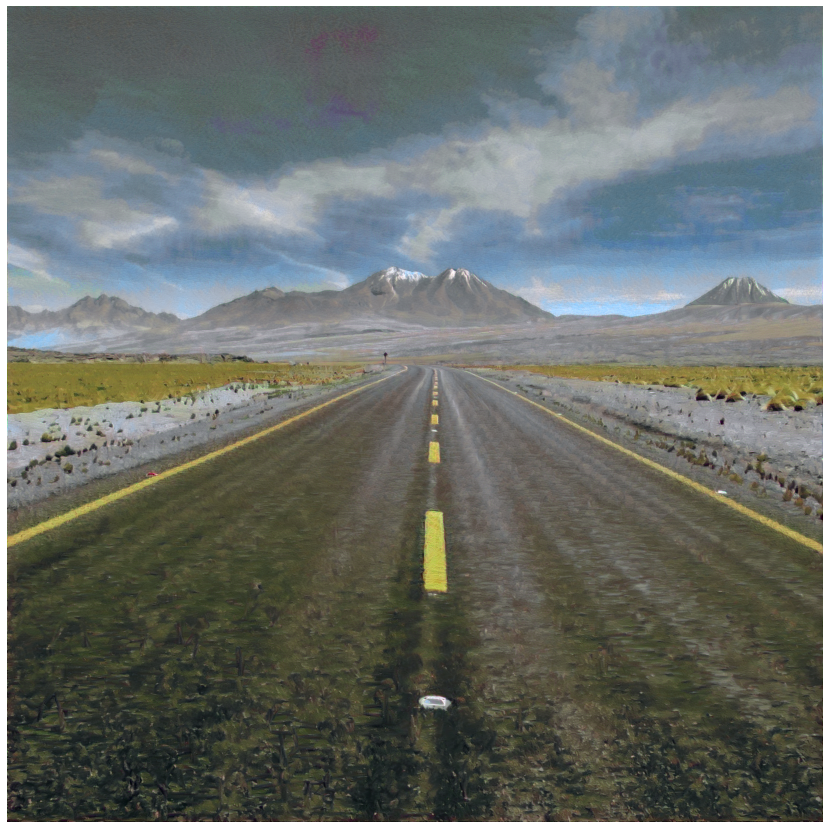

In [26]:
plt.figure(figsize=(15,15))
splot(mm_norm(target))

# Different conv layers for content (only)

## Experiment list
- Use a style image that has more texture
- A content image with some regions of low texture
- See what happens when more layers are accounted for.
- See what happens when either style or content cost is set to zero.
- See what happens when the target image is either noise, content image, style image.
- Find the best set of params then run the experiments using those, maybe use LBFGS
- Different layers being used for content cost
- Different layers being used for style cost

## References
- [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576)
- [NEURAL TRANSFER USING PYTORCH](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html)